In [1]:
from __future__ import division, print_function
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import pylab as plt
import datetime as dt
from datetime import datetime as ddt, date, time
import math
import statsmodels.api as sm

import seaborn as sns
%pylab inline

from sklearn.model_selection import train_test_split, StratifiedKFold
#from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
#from sklearn.pipeline import Pipeline
#from sklearn.preprocessing import StandardScaler

#from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
#from sklearn.linear_model import LinearRegression, LogisticRegression
#from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score
import os
from tqdm import  tqdm #tnrange, tqdm_notebook as

from numba import jit
from multiprocessing.dummy import Pool as ThreadPool

Populating the interactive namespace from numpy and matplotlib


In [2]:
@jit#(nopython=True)
def loadMappings(path):
    xl = pd.ExcelFile(path)
    #xl
    map_podp = xl.parse('Подписант КЗ')
    map_zb = xl.parse('Зак_Блок')
    map_dep = xl.parse('Департамент')
    map_upr = xl.parse('Управление')
    map_otd = xl.parse('Отдел')
    map_podp.dropna(inplace = True)
    map_zb.dropna(inplace = True)
    map_dep.dropna(inplace = True)
    map_upr.dropna(inplace = True)
    map_otd.dropna(inplace = True)
    print('Меппинги загружены')
    return map_podp, map_zb, map_dep, map_upr, map_otd
     
#@jit#(nopython=True)
def loadOrderFile(path, page):
    global map_podp, map_zb, map_dep, map_upr,map_otd
    
    xl = pd.ExcelFile(path)
    df = xl.parse(page)
    colsToDrop = ['Год', 'Месяц', 'Номер строки', 'ID для консолидации','ID АС ЦУП мастер-заказа',
              'Комментарий УСПП','Название заказа (КЗ)','ООУ (открытие)','Дата распоряжения о внедрении по КЗ', 'Номер СП',
              'Актуальный номер спецификации','Подписанты', 'Аккаунт менеджер заказа', 'Заказчик',
              'Тип заказа','Название заказа','Менеджера заказа','Задача в заказе (что делали)', 'Табельный номер',
              'Основание командировки (работы в выходные дни)', 'Период командировки (работы в выходные дни)', 
              'Место командировки', 'Запланированный результат', 'Фактический результат','Комментарий МЗ к отчету',
              'Пояснения к изменению объема трудозатрат по результатам согласования с заказчиком', 'e-mail',
              'Согласовано АКТ', 'Отработано по табелю включая командировки, дни',
              'Нормированные по сотруднику утвержденные трудозатраты, дни','Отработано по табелю включая командировки, часы',
              'Фактические трудозатраты введенные сотрудником, часы','Фактические трудозатраты, подтвержжденные менеджером заказа, часы',
              'Нормированный  % загрузки по сотруднику','Нормирование по сотруднику, часы','Стоимость трудозатрат(руб.)',
              'Стоимость трудозатрат, согласованных заказчиком (руб)','Стоимость командировок (руб.)',
              'Стоимость нормированных командировок (руб.)','Стоимость командировок, согласованных заказчиком (руб.)',
              'Стоимость работ в выходные (руб.)','Стоимость работ в выходные, согласованная с заказчиком (руб.)',
              'ИТОГО стоимость работ, согласованная заказчиком(руб.)','Ставка \nСБТ-Банк (руб.)','Этап СП', 
              'Дата начала этапа СП','Базовая дата окончания этапа СП', 'Прогнозная дата окончания этапа СП',
              'Фактическая дата окончания этапа СП', 'Статус этапа СП','Базовая дата окончания уточненного этапа СП','Статус',
              'Дата закрытия КЗ','Дата окончания КЗ','Компания','Дата закрытия на ООУ']
            
    try:
        df.drop(colsToDrop,inplace=True, axis =1)
    except ValueError:
        colsToDrop.remove('Отработано по табелю включая командировки, дни')
        colsToDrop.remove('Отработано по табелю включая командировки, часы')
        colsToDrop = colsToDrop + ['Отработанное по табелю время работы на Sbergile - команду включая командировки, дни',
                                  'Отработано по табелю время работы на Sbergile - команду включая командировки, часы',
                                  'Отработанное по табелю время работы не на Sbergile - команду включая командировки, часы',
                                  'Отработанное по табелю время работы не на Sbergile - команду включая командировки, дни']
        df.drop(colsToDrop,inplace=True, axis =1)
        
    df['Подписант КЗ'].fillna('#nd',inplace=True)
    df['Заказчик КЗ'].fillna('#nd.#nd.#nd.#nd.#nd.#nd',inplace=True)
    df['Заказчик КЗ']=df['Заказчик КЗ']+'.#nd.#nd.#nd.#nd.#nd.#nd'
   
    df['Дата открытия на ООУ'].fillna(method ='ffill',inplace=True)
    df['Статус проекта в портфеле Банка для КЗ'].fillna('#nd',inplace=True)
    df['Уточненный тип договора '].fillna('Fix price',inplace=True)
    df['Уточненный тип СП'].fillna('Разработка',inplace=True)
    df['Уточненный номер этапа СП'].fillna(0,inplace=True)
    df['Дата начала этапа'].fillna(0,inplace=True)
    df['Дата окончания этапа'].fillna(0,inplace=True)
    df['Статус уточненного этапа СП'].fillna('#nd',inplace=True)
    df['Статус акта по этапу'].fillna('#nd',inplace=True)
    df['ID АС ЦУП'].fillna('#nd',inplace=True)
    df['Департамент'].fillna('#nd',inplace=True)
    df['Управление'].fillna('#nd',inplace=True)
    df['Согласование аккаунт-менеджера'].fillna('#nd',inplace=True)
    df['Функциональный блок'].fillna('#nd',inplace=True)
    try: 
        df['Тип командировки (Зарубежная /По России)'].fillna('#nd',inplace=True)
        df['Работа в Sbergile'].fillna('#nd',inplace=True)
    except KeyError:
        df['Тип командировки (Зарубежная /По России)'] = '#nd'
        df['Работа в Sbergile'] = '#nd'
    df.dropna(inplace = True)
    #Дополнить кодировку блоков
    df['Зак_Блок']  = df['Функциональный блок']
    df.drop(['Функциональный блок'],inplace=True, axis =1)
    #df['Зак_Блок']=df.apply(lambda r: r['Заказчик КЗ'].split('.')[3], axis=1)
    df['Зак_Блок']=df.apply(lambda r: r['Заказчик КЗ'].split('.')[3] if ((r['Зак_Блок'])=='#nd') else r['Зак_Блок'], axis=1)
    
    df['Зак_стр_п']=df.apply(lambda r: r['Заказчик КЗ'].split('.')[4], axis=1)
    df['Зак_менеджер']=df.apply(lambda r: r['Заказчик КЗ'].split('.')[5], axis=1)
    df.drop('Заказчик КЗ',inplace=True, axis =1)
    
    for index, row in map_podp.iterrows():
        df.loc[df['Подписант КЗ']==row['From'],'Подписант КЗ']=row['To']
    for index, row in map_zb.iterrows():
        df.loc[df['Зак_Блок']==row['From'],'Зак_Блок']=row['To']
    for index, row in map_dep.iterrows():
        df.loc[df['Департамент']==row['From'],'Департамент']=row['To']
    for index, row in map_upr.iterrows():
        df.loc[df['Управление']==row['From'],'Управление']=row['To']
    
    df.loc[df['Категория']=='Billable staff','Категория']='B'
    df.loc[df['Категория']=='Non-billible staff','Категория']='N'
    df.loc[df['Наличие СП']=='#Н/Д','Наличие СП']='Наличие СП'

    df['Грейд']=df['Грейд'].astype('int32')
    print(path)
    return df

#@jit
def loadWorkFile1(path, page):
    global map_podp, map_zb, map_dep, map_upr,map_otd
    xl = pd.ExcelFile(path)
    df = xl.parse(page)
    df = df.iloc[1:]#отбрасываем строчку с номерами
    colsToDrop = ['ID АС ЦУП','Название заказа','Компания','Парковка','Внешний грейд', 'Подписант','Тип заказа',
               'Чел/часы\nпо дням','Плановый процент загрузки\nпо дням','Дата начала списания',  'Дата последнего списания',
               'Чел/дни.1','Фактическая стоимость (руб)','Резерв (п.14-п.17)','Коэффициент использования ресурса, % (п.17/п.14)']
    try:
        df.drop(colsToDrop,inplace=True, axis =1)
    except ValueError:
        colsToDrop.remove('Подписант')
        
        try:
            df.drop(colsToDrop,inplace=True, axis =1)
        except ValueError:
            colsToDrop.remove('Тип заказа')
            df.drop(colsToDrop,inplace=True, axis =1)
    df.dropna(inplace = True)
    
    for index, row in map_dep.iterrows():
        df.loc[df['Департамент']==row['From'],'Департамент']=row['To']
    for index, row in map_upr.iterrows():
        df.loc[df['Управление']==row['From'],'Управление']=row['To']
    
    df.loc[df['Категория ресурса']=='Billable staff','Категория ресурса']='B'
    df.loc[df['Категория ресурса']=='Non-billible staff','Категория ресурса']='N'
    df['Внутренний грейд'].fillna('Внутренний грейд',inplace=True)
    df['Внутренний грейд']=df['Внутренний грейд'].astype('int32')

    print(path)
    return df


#загрузка "41" отчётов
#@jit#(nopython=True)
def loadOrders(path):
    files = os.listdir(path) 
    #xlsx = filter(lambda x: x.endswith('.xlsx'), files)
    xlsx = [file for file in files if file.endswith('.xlsx')]
    datas = [loadOrderFile(path+xlsx[i], 'actworkcostreport.rdl') for i in range(len(xlsx))]
    return pd.concat(datas,ignore_index=True)

#загрузка отчётов "БП2"
#@jit#(nopython=True)
def loadWorks1(path):
    files = os.listdir(path) 
    #xlsx = filter(lambda x: x.endswith('.xlsx'), files)
    xlsx = [file for file in files if file.endswith('.xlsx')]
    datas = [loadWorkFile1(path+xlsx[i], 'planningresources1.rdl') for i in range(len(xlsx))]
    return pd.concat(datas, ignore_index=True)

In [3]:
#грузим данные 
map_podp, map_zb, map_dep, map_upr,map_otd = loadMappings('data\\mapping\\mapping.xlsx')
pre_df = loadOrders('data\\41\\')
pre_df2 = loadWorks1('data\\БП2\\')


Меппинги загружены
data\41\41 2015 H1.xlsx
data\41\41 2015 H2.xlsx
data\41\41 2016 All.xlsx
data\41\41_2017H.xlsx
data\41\41_2017Q3.xlsx
data\БП2\БП2 (57) 10.xlsx
data\БП2\БП2 (57) 11.xlsx
data\БП2\БП2 (57) 12.xlsx
data\БП2\БП2 (57) 15-1.xlsx
data\БП2\БП2 (57) 15-10.xlsx
data\БП2\БП2 (57) 15-11.xlsx
data\БП2\БП2 (57) 15-12.xlsx
data\БП2\БП2 (57) 15-2.xlsx
data\БП2\БП2 (57) 15-3.xlsx
data\БП2\БП2 (57) 15-4.xlsx
data\БП2\БП2 (57) 15-5.xlsx
data\БП2\БП2 (57) 15-6 версия.xlsx
data\БП2\БП2 (57) 15-7.xlsx
data\БП2\БП2 (57) 15-8.xlsx
data\БП2\БП2 (57) 15-9.xlsx
data\БП2\БП2 (57) 1_c.xlsx
data\БП2\БП2 (57) 2.xlsx
data\БП2\БП2 (57) 3.xlsx
data\БП2\БП2 (57) 4.xlsx
data\БП2\БП2 (57) 5.xlsx
data\БП2\БП2 (57) 6.xlsx
data\БП2\БП2 (57) 7.xlsx
data\БП2\БП2 (57) 8.xlsx
data\БП2\БП2 (57) 9.xlsx
data\БП2\БП2-2017 второе полугодие.xlsx
data\БП2\БП2-2017 первое полугодие.xlsx


In [4]:
#закомментировать если данные не менялись
pre_df2.to_excel('data/pre_df2_1.xlsx')
pre_df.to_excel('data/pre_df_1.xlsx')

#раскомментировать если работаем с тем, что раньше грузили
#xl = pd.ExcelFile('data/pre_df2.xlsx')
#pre_df2 = xl.parse('Sheet1')
#xl = pd.ExcelFile('data/pre_df.xlsx')
#pre_df2 = xl.parse('Sheet1')
!telegram-send 'файлы_загружены'

In [3]:
#в качестве менеджера клиентского заказа, аккаунт менеджера и менеджера заказчика указываем того у которого больше всего записей по этому КЗ
#@jit(nopython=True)
@jit
def fillMax( fFill, fMaxCount):
    global pre_df
    df_mgr_count = pd.DataFrame(pre_df.groupby(['ID АРИАДНЫ',fFill])[fMaxCount].count()).reset_index()
    df_mgr_count = df_mgr_count.rename(columns={fMaxCount: 'кол-во'})
    df_mgr_count = df_mgr_count.groupby(['ID АРИАДНЫ'], as_index=False).max()
    #df_mgr_count.drop(['кол-во'], inplace=True, axis=1) 
    for index, row in df_mgr_count.iterrows():
        pre_df.loc[pre_df['ID АРИАДНЫ']==row['ID АРИАДНЫ'],fFill]=row[fFill]

#в случае, если по заказу есть данные и #nd -пишем нужные нам данные 
@jit#(nopython=True)
def fillND( fFill, fMaxCount):
    global pre_df
    df_mgr_count = pd.DataFrame(pre_df.groupby(['ID АРИАДНЫ',fFill])[fMaxCount].count()).reset_index()
    df_mgr_count = df_mgr_count.rename(columns={fMaxCount: 'кол-во'})
    df_mgr_count = df_mgr_count[df_mgr_count[fFill]!='#nd']
    df_mgr_count = df_mgr_count.groupby(['ID АРИАДНЫ'], as_index=False).max()
    for index, row in df_mgr_count.iterrows():
        pre_df.loc[pre_df['ID АРИАДНЫ']==row['ID АРИАДНЫ'],fFill]=row[fFill]

#делаем ключ уникальным pre_df
@jit#(nopython=True)
def makeKeyUniqe1():
    global pre_df
    
    df_id_ar = pd.DataFrame(pre_df.groupby(['key1'])['Подписант КЗ'].count()).reset_index()
    df_id_ar.drop(['Подписант КЗ'], inplace=True, axis=1) 
    for index, row in df_id_ar.iterrows():
        df_loc = pre_df[pre_df['key1']==row['key1']][['key1','ч/д_факт']]
        df_loc['ind']=df_loc.index
        df_loc.sort_values(['ч/д_факт'], ascending=[False], inplace=True)
        df_loc_sort = pd.DataFrame(df_loc[['key1','ч/д_факт','ind']]).reset_index()
        #print(df_loc_sort.head(2))
        df_loc_sort['row_n']=df_loc_sort.index
        #df_loc_sort.drop(['index'], inplace=True, axis=1) 
        df_loc_sort['row_n']=df_loc_sort['key1']+'_'+df_loc_sort['row_n'].astype(str)
        for index, row in df_loc_sort.iterrows():
            pre_df.loc[(pre_df.index==row['ind']),'key2']=row['row_n']

#делаем ключ уникальным pre_df2
@jit#(nopython=True)
def makeKeyUniqe2():
    global pre_df2
    
    df_id_ar = pd.DataFrame(pre_df2.groupby(['key1'])['Категория'].count()).reset_index()
    df_id_ar.drop(['Категория'], inplace=True, axis=1) 
    for index, row in df_id_ar.iterrows():
        df_loc = pre_df2[pre_df2['key1']==row['key1']][['key1','ч/д_план']]
        df_loc['ind']=df_loc.index
        df_loc.sort_values(['ч/д_план'], ascending=[False], inplace=True)
        df_loc_sort = pd.DataFrame(df_loc[['key1','ч/д_план','ind']]).reset_index()
        df_loc_sort['row_n']=df_loc_sort.index
        #df_loc_sort.drop(['index'], inplace=True, axis=1) 
        df_loc_sort['row_n']=df_loc_sort['key1']+'_'+df_loc_sort['row_n'].astype(str)
        for index, row in df_loc_sort.iterrows():
            pre_df2.loc[(pre_df2.index==row['ind']),'key2']=row['row_n']

@jit#(nopython=True)
def makeFullDS(): #заполнение пропусков наиболее часто встречающимся значением по заказу
    global df

    cols_id = ['ID АРИАДНЫ']
    #'ID АС ЦУП',
    colsToFill = ['Аккаунт менеджер КЗ','Дата открытия на ООУ',
                  'Зак_Блок','Зак_менеджер','Зак_стр_п','Менеджер (КЗ)','Наличие СП',
                  'Подписант КЗ','Прогноз/Факт','Работа в Sbergile',
                  'Согласование аккаунт-менеджера','Справочник типа заказа',
                  'Статус акта по этапу','Статус проекта в портфеле Банка для КЗ',
                  'Тип КЗ', 'Тип СП', 'Тип договора', 'Тип затрат',
                  'Тип командировки (Зарубежная /По России)',
                  'Уточненный номер этапа СП', 'Уточненный тип СП',
                  'Уточненный тип договора ']
    groupCols = cols_id + colsToFill
    df_orders = pd.DataFrame(df.groupby(groupCols)['key2'].count()).reset_index()
    df_orders = df_orders.rename(columns={'key2': 'кол-во'})
    df_orders = df_orders.groupby('ID АРИАДНЫ', as_index=False).max()
    #pbar_df = tqdm(df_orders.shape[0]+14)
    for index, row in df_orders.iterrows():
        #set = pd.DataFrame(df.loc[df['ID АРИАДНЫ']==row['ID АРИАДНЫ'],'Аккаунт менеджер КЗ'][0:1]).reset_index()
        #if (pd.isnull(set['Аккаунт менеджер КЗ'][0])):
            for field in colsToFill: 
                df.loc[df['ID АРИАДНЫ']==row['ID АРИАДНЫ'],field]=row[field]
            #pbar_df.update(1)
    #pbar_fill.close
    #return df

In [6]:
pbar_link = tqdm(total=7)
#приведение колонок к нужному типу данных
pre_df['Дата открытия на ООУ'] = pd.to_datetime(pre_df['Дата открытия на ООУ'])
pre_df['Дата начала этапа'] = pd.to_datetime(pre_df['Дата начала этапа'])
pre_df['Дата окончания этапа'] = pd.to_datetime(pre_df['Дата окончания этапа'])
pre_df2['Дата начала'] = pd.to_datetime(pre_df2['Дата начала'])
pre_df2['Дата окончания'] = pd.to_datetime(pre_df2['Дата окончания'])

pre_df2['Дл раб план'] = pre_df2['Дата окончания'].map(dt.datetime.toordinal) - pre_df2['Дата начала'].map(dt.datetime.toordinal)
pre_df2['Дата начала'].fillna(method = 'ffill',inplace=True)
pre_df['Дата начала этапа'].fillna(method = 'ffill',inplace=True)
pre_df['Дл раб факт'] = pre_df['Дата окончания этапа'].map(dt.datetime.toordinal) - pre_df['Дата начала этапа'].map(dt.datetime.toordinal)

pre_df = pre_df.rename(columns={'Трудозатраты,  подтвержденные заказчиком, дни': 'ч/д_факт'})
pre_df2 = pre_df2.rename(columns={'Чел/дни': 'ч/д_план','ID заказа Ариадны':'ID АРИАДНЫ','Внутренний грейд':'Грейд','Категория ресурса':'Категория','ФИО/Наименование':'ФИО'})

#устраняем противоречия в заказчиках, и подписантах
#print('0/7')
fillMax('Менеджер (КЗ)','Подписант КЗ')
#print('1/7')
pbar_link.update(1)
fillMax('Аккаунт менеджер КЗ','Подписант КЗ')
#print('2/7')
pbar_link.update(1)
fillMax('Зак_менеджер','Подписант КЗ')
#print('3/7')
pbar_link.update(1)
fillND('Зак_Блок','Подписант КЗ')
#print('4/7')
pbar_link.update(1)
fillND('Согласование аккаунт-менеджера','Подписант КЗ')
#print('5/7')
pbar_link.update(1)
#формируем ключи для склеивания
pre_df['key1'] = pre_df['ID АРИАДНЫ'].astype(str)+'_'+ pre_df['ФИО'].astype(str)#+ pre_df['Управление'].astype(str)+'_'+ pre_df['Должность'].astype(str)+'_'+ pre_df['Грейд'].astype(str)+'_'+ pre_df['ФИО'].astype(str)
pre_df2['key1'] = pre_df2['ID АРИАДНЫ'].astype(str)+'_'+ pre_df2['ФИО'].astype(str)#+'_'+ pre_df2['Управление'].astype(str)+'_'+ pre_df2['Должность'].astype(str)+'_'+ pre_df2['Грейд'].astype(str)+'_'+ pre_df2['ФИО'].astype(str)
makeKeyUniqe1()
#print('6/7')
pbar_link.update(1)
makeKeyUniqe2()
#print('7/7')

pre_df.drop(['key1'], inplace=True, axis=1)
pre_df2.drop(['key1'], inplace=True, axis=1)

pbar_link.update(1)
pbar_link.close()

100%|████████████████████████████████████████| 7/7 [9:38:17<00:00, 8556.02s/it]


In [7]:
pre_df2.to_excel('data/pre_df_u2_1.xlsx')
pre_df.to_excel('data/pre_df_u_1.xlsx')


#раскомментировать если работаем с тем, что раньше грузили
#xl = pd.ExcelFile('data/pre_df_u2.xlsx')
#pre_df2 = xl.parse('Sheet1')
#xl = pd.ExcelFile('data/pre_df_u.xlsx')
#pre_df = xl.parse('Sheet1')

!telegram-send 'связи_построены'

In [8]:
#df = pre_df2.join(pre_df, how ='inner', on=('key1'), lsuffix='', rsuffix='_y')
#df = pre_dfg2.merge(pre_dfg, how ='inner', on=('key1'),suffixes=('', '_y'))
#объединяем плановые и фактические значения 
pbar_df = tqdm(total=15)

df = pre_df.merge(pre_df2, how ='outer', on=('key2'),suffixes=('', '_y'))
pbar_df.update(1)
#дополняем факт известными плановыми значениями
df['ID АРИАДНЫ'] = df.apply(lambda r: r['ID АРИАДНЫ_y'] if (pd.isnull(r['ID АРИАДНЫ'])) else r['ID АРИАДНЫ'], axis=1)
pbar_df.update(1)
df['Грейд'] = df.apply(lambda r: r['Грейд_y'] if (pd.isnull(r['Грейд'])) else r['Грейд'], axis=1)
pbar_df.update(1)
df['Департамент'] = df.apply(lambda r: r['Департамент_y'] if (pd.isnull(r['Департамент'])) else r['Департамент'], axis=1)
pbar_df.update(1)
df['Управление'] = df.apply(lambda r: r['Управление_y'] if (pd.isnull(r['Управление'])) else r['Управление'], axis=1)
pbar_df.update(1)
df['Должность'] = df.apply(lambda r: r['Должность_y'] if (pd.isnull(r['Должность'])) else r['Должность'], axis=1)
pbar_df.update(1)
df['ФИО'] = df.apply(lambda r: r['ФИО_y'] if (pd.isnull(r['ФИО'])) else r['ФИО'], axis=1)
pbar_df.update(1)
df['Категория'] = df.apply(lambda r: r['Категория_y'] if (pd.isnull(r['Категория'])) else r['Категория'], axis=1)
pbar_df.update(1)
df['Статус уточненного этапа СП'] = df.apply(lambda r: 'В ожидании' if (pd.isnull(r['Категория'])) else r['Категория'], axis=1)
pbar_df.update(1)
#подчищаем задвоенные колонки
colsToDrop = ['ID АРИАДНЫ_y','Департамент_y','Управление_y','Должность_y','Грейд_y','ФИО_y','Категория_y']
df.drop(colsToDrop,inplace=True, axis =1)
pbar_df.update(1)

makeFullDS()
pbar_df.update(1)

#заводим поле по которому отличаем то, что есть, от того, что надо прогнозировать
df['Статус']=df.apply(lambda r: 1 if (r['Итого стоимость работ (руб.)']>=0) else 0, axis=1)
pbar_df.update(1)
#дополнительнные коэффициенты для прогноза
#df['коэфф_сроки'] = df.apply(lambda r: r['Дл раб факт']/r['Дл раб план'] if (r['Дл раб план']>0) else 10, axis=1)
pbar_df.update(1)
#df['коэфф_труд'] = df.apply(lambda r: r['ч/д_факт']/r['ч/д_план'] if (r['ч/д_план']>0) else 10, axis=1)
pbar_df.update(1)
#df['коэфф_деньги'] = df.apply(lambda r: r['Итого стоимость работ (руб.)']/r['Стоимость (руб)'] if (r['Стоимость (руб)']>0) else 10, axis=1)
pbar_df.update(1)
pbar_df.close()    


100%|█████████████████████████████████████| 15/15 [12:08:14<00:00, 2912.94s/it]


In [9]:
df.tail(5)

,ID АРИАДНЫ,ID АС ЦУП,Аккаунт менеджер КЗ,Грейд,Дата начала этапа,Дата окончания этапа,Дата открытия на ООУ,Департамент,Должность,Зак_Блок,...,Дл раб факт,key2,Активен,Дата начала,Дата окончания,ч/д_план,Стоимость (руб),Плановый процент загрузки,Дл раб план,Статус
565423,SBT-029488,NaN,Солдаткина Наталья Сергеевна.ЦА,11.0,NaT,NaT,2017-06-26,Департамент технологий финансовых рынков и упр...,Главный разработчик по системам управления рис...,CIB,...,NaN,SBT-029488_Гладких Борис Александрович_1,Да,2017-06-26,2017-11-01,1.075269,21376.344085,0.215054,128.0,0
565424,SBT-029488,NaN,Солдаткина Наталья Сергеевна.ЦА,12.0,NaT,NaT,2017-06-26,Департамент технологий финансовых рынков и упр...,Главный архитектор,CIB,...,NaN,SBT-029488_Кузовкин Павел Валерьевич_1,Да,2017-06-26,2017-11-01,0.107527,2888.172045,0.021505,128.0,0
565425,SBT-029488,NaN,Солдаткина Наталья Сергеевна.ЦА,10.0,NaT,NaT,2017-06-26,Департамент технологий финансовых рынков и упр...,Ведущий разработчик по системам управления рис...,CIB,...,NaN,SBT-029488_Складчиков Алексей Евгеньевич_1,Да,2017-06-26,2017-11-01,0.806452,11717.741935,0.161290,128.0,0
565426,SBT-029488,NaN,Солдаткина Наталья Сергеевна.ЦА,11.0,NaT,NaT,2017-06-26,Департамент технологий финансовых рынков и упр...,Руководитель разработки,CIB,...,NaN,SBT-029488_Шаронов Александр Евгеньевич_1,Да,2017-06-26,2017-11-01,0.107527,2137.634410,0.021505,128.0,0
565427,SBT-029711,NaN,NaN,10.0,NaT,NaT,NaT,Департамент развития фронтальных систем и элек...,Главный инженер,NaN,...,NaN,SBT-029711_Петриков Максим Николаевич_1,Да,2017-06-29,2018-10-29,0.830270,12063.827028,0.415135,487.0,0


In [10]:
#заполняем медианами плановые длительности по ЦК там, нет данных по срокам
#p_med = df[['key2','Дл раб план']]
#p_med = p_med[p_med['Дл раб план']>=0]
#p_median = p_med.groupby('key2')['Дл раб план'].median()
#df['Дл раб план'] = df.apply(lambda r: p_median[r['key2']] if ((r['Дл раб план']<0) or (r['Дл раб план']>p_median[r['key2']]*5)) else r['Дл раб план'], axis=1)
#заполняем медианами  фактические длительности по ЦК там, нет данных по срокам
#f_med = df[['key2','Дл раб факт']]
#f_med = f_med[f_med['Дл раб факт']>=0]
#f_median = f_med.groupby('key2')['Дл раб факт'].median()
#df_full['Дл раб факт'] = df_full.apply(lambda r: f_median[r['key2']] if ((r['Дл раб факт']<0) or (r['Дл раб факт']>f_median[r['key2']]*5)) else r['Дл раб факт'], axis=1)

#df['Статус']=df.apply(lambda r: 1 if (r['Итого стоимость работ (руб.)']>0) else 0, axis=1)
#дополнительнные коэффициенты для прогноза
#df['коэфф_сроки'] = df.apply(lambda r: r['Дл раб факт']/r['Дл раб план'] if (r['Дл раб план']>0) else 10, axis=1)
#df['коэфф_труд'] = df.apply(lambda r: r['ч/д_факт']/r['ч/д_план'] if (r['ч/д_план']>0) else 10, axis=1)
#df['коэфф_деньги'] = df.apply(lambda r: r['Итого стоимость работ (руб.)']/r['Стоимость (руб)'] if (r['Стоимость (руб)']>0) else 10, axis=1)

#записываем промежуточный результат, чтобы потом избежать предрасчёта ключей
df.to_excel('data/df_g.xlsx')

#сверки того, что всё загрузилось и склеилось корректно
print(pre_df['Итого стоимость работ (руб.)'].sum())
print(df['Итого стоимость работ (руб.)'].sum())
print(pre_df['ч/д_факт'].sum())
print(df['ч/д_факт'].sum())
print(pre_df['Дл раб факт'].sum())
print(df['Дл раб факт'].sum())

print(pre_df2['Стоимость (руб)'].sum())
print(df['Стоимость (руб)'].sum())
print(pre_df2['Дл раб план'].sum())
print(df['Дл раб план'].sum())
print(pre_df2['ч/д_план'].sum())
print(df['ч/д_план'].sum())

!telegram-send 'таблицы_нормализованы'

49963570937.00469
49963570937.00469
3399364.3950001677
3399364.3950001677
120131339
120131339.0
58930636892.98374
58930636892.98264
103577076
103577076.0
3916309.324918242
3916309.324918288


In [ ]:
#сохраняем, чтобы потом не париться, пропустить - если не надо сохранять 
#df.to_csv('data\\df.csv',index_label = 'ind')

In [4]:
#загружаем данные 
#df= pd.read_csv('data\\df.csv',index_col = 'ind', parse_dates=True, encoding='1251') 
#df.head(5)

#раскомментировать если работаем с тем, что раньше грузили
xl = pd.ExcelFile('data/cache/pre_df_u2_1.xlsx')
pre_df2 = xl.parse('Sheet1')
xl = pd.ExcelFile('data/cache/pre_df_u_1.xlsx')
pre_df = xl.parse('Sheet1')
xl= pd.ExcelFile('data/cache/df_g.xlsx')
df = xl.parse('Sheet1')

#сверки того, что всё загрузилось и склеилось корректно
print(pre_df['Итого стоимость работ (руб.)'].sum())
print(df['Итого стоимость работ (руб.)'].sum())
print(pre_df['ч/д_факт'].sum())
print(df['ч/д_факт'].sum())
print(pre_df['Дл раб факт'].sum())
print(df['Дл раб факт'].sum())

print(pre_df2['Стоимость (руб)'].sum())
print(df['Стоимость (руб)'].sum())
print(pre_df2['Дл раб план'].sum())
print(df['Дл раб план'].sum())
print(pre_df2['ч/д_план'].sum())
print(df['ч/д_план'].sum())
#print(df.columns)

!telegram-send 'таблицы_загружены'

49963570937.00469
49963570937.00469
3399364.3950001677
3399364.3950001677
120131339
120131339.0
58930636892.98374
58930636892.98264
103577076
103577076.0
3916309.324918242
3916309.324918288


In [5]:
predictors_res  = ['Плановый процент загрузки', 'Дл раб план', 'Стоимость (руб)',
       'ч/д_план', 'Подписант КЗ', 'Аккаунт менеджер КЗ', 'Менеджер (КЗ)',
       'Дата открытия на ООУ', 'Статус проекта в портфеле Банка для КЗ',
       'Наличие СП', 'Уточненный тип договора ', 'Уточненный тип СП',
       'Статус акта по этапу', 'Зак_Блок', 'Зак_менеджер', 'Тип КЗ','ФИО',
       'Справочник типа заказа', 'ID АРИАДНЫ', 'Департамент', 'Управление','Отдел','Должность',
       'Согласование аккаунт-менеджера', 'Грейд', 'Прогноз/Факт', 'Работа в Sbergile','Активен',
       'Уточненный номер этапа СП', 'Дл раб факт','Тип командировки (Зарубежная /По России)',
       'Итого стоимость работ (руб.)', 'ч/д_факт',# 'коэфф_сроки', 'коэфф_труд', 'коэфф_деньги',
       'Тип СП']
#
df_1 = df[df['Статус']==1][predictors_res]
df_1.dropna(inplace=True)

cols_f = ['Подписант КЗ', 'Аккаунт менеджер КЗ', 'Менеджер (КЗ)',
       'Статус проекта в портфеле Банка для КЗ',
       'Наличие СП', 'Уточненный тип договора ', 'Уточненный тип СП',
       'Статус акта по этапу', 'Зак_Блок', 'Зак_менеджер', 'Тип КЗ',
       'Справочник типа заказа', 'Департамент', 'Управление','Отдел','Должность','ФИО',
       'Согласование аккаунт-менеджера', 'Прогноз/Факт','Тип СП', 'Работа в Sbergile','Активен',
       'Тип командировки (Зарубежная /По России)']
#

for col in cols_f:
        df_1[col+'_num'] = pd.factorize(df_1[col])[0]

predictors = []
for col in cols_f:
        predictors.append(col+'_num')

#
predictors = predictors + ['Грейд','Уточненный номер этапа СП','ч/д_план', 'Стоимость (руб)', 'Дл раб план']   
        
#print(df_1[df_1['Статус']==0].shape)
#print(predictors)

In [6]:
#df_1['Заказчик КЗ_num'] = np.log1p(df_1['Заказчик КЗ_num'])
#df_1['Менеджер (КЗ)_num'] = np.log1p(df_1['Менеджер (КЗ)_num'])
#df_1['Тип СП_num'] = np.log1p((df_1['Тип СП_num']))
#df_1['Уточненный номер этапа СП_num'] = np.log1p((df_1['Уточненный номер этапа СП_num']))

#df_1['Статус акта по этапу_num'] = np.log1p(df_1['Статус акта по этапу_num'])
#df_1['Должность_num'] = np.log1p(df_1['Должность_num'])
#df_1['Грейд_num'] = np.log1p(df_1['Грейд_num'])
#df_1['ч/д_план'] = np.log1p(df_1['ч/д_план'])

In [7]:
scaler = StandardScaler()
scaler.fit(df_1[predictors])

results = ['Итого стоимость работ (руб.)','ч/д_факт','Дл раб факт']#, 'коэфф_сроки', 'коэфф_труд','коэфф_деньги']
trg = df_1[results]
trn = pd.DataFrame(scaler.transform(df_1[predictors]),columns=predictors)

Xtrn, Xtest, Ytrn, Ytest = train_test_split(trn, trg, test_size=0.3,random_state=17)

In [8]:
#tmp = {}
#строим случайный лес по срокам
#forest_l = RandomForestRegressor(n_estimators=100, n_jobs=-1, max_features ='sqrt',random_state=17)
#forest_l.fit(Xtrn, Ytrn.iloc[:,4])
#tmp['R2_Y%s'%str(1)] = r2_score(Ytest.iloc[:,4], forest_l.predict(Xtest))
#tmp

In [9]:
tmp = {}
models = {}
pbar = tqdm(total=6)
    
for mod in results:
        forest = RandomForestRegressor(n_estimators=300, n_jobs=-1,  max_features =28,random_state=17)
        forest.fit(Xtrn, Ytrn.loc[:,mod])
        tmp[mod] = r2_score(Ytest.loc[:,mod], forest.predict(Xtest))
        models[mod] =forest
        pbar.update(2)
        #params = {'n_estimators': 2000, 'max_depth': 15, 'min_samples_leaf': 1,'min_samples_split':2,
        #          'subsample': 0.8, 'max_features': 28, 'random_state': 17}
        #booster = GradientBoostingRegressor(**params)
        #booster.fit(Xtrn, Ytrn.loc[:,mod])
        #tmp[mod+' boost'] = r2_score(Ytest.loc[:,mod], booster.predict(Xtest))
        #models[mod+' boost'] =booster
        #pbar.update(1)
        #forest = RandomForestRegressor(n_estimators=100, n_jobs=-1,random_state=17)
        #forest_params = {'max_depth': range(22,30),'max_features': range(27,28)}
        #forest_grid = GridSearchCV(forest, forest_params, cv=5, n_jobs=-1, verbose=True)
        #forest_grid.fit(Xtrn, Ytrn.loc[:,mod])
        #print([forest_grid.best_params_, forest_grid.best_score_])
        #tmp[mod] = r2_score(Ytest.loc[:,mod], forest_grid.predict(Xtest))
        #models[mod] =forest_grid
#print(models)
pbar.close()
print(tmp)

!telegram-send 'модель_обучена'

100%|████████████████████████████████████████████| 6/6 [02:27<00:00, 25.02s/it]


{'Итого стоимость работ (руб.)': 0.80572458862401153, 'ч/д_факт': 0.77766212294037518, 'Дл раб факт': 0.77771670258870018}


In [10]:
dfClearCols = ['ID АРИАДНЫ', 'ID АС ЦУП', 'Аккаунт менеджер КЗ', 'Грейд',
               'Дата начала этапа', 'Дата окончания этапа', 'Дата открытия на ООУ',
               'Департамент', 'Должность', 'Зак_Блок', 'Зак_менеджер', 'Зак_стр_п',
               'Итого стоимость работ (руб.)', 'Категория', 'Менеджер (КЗ)',
               'Наличие СП', 'Отдел', 'Подписант КЗ', 'Прогноз/Факт',
               'Работа в Sbergile', 'Согласование аккаунт-менеджера',
               'Справочник типа заказа', 'Статус акта по этапу',
               'Статус проекта в портфеле Банка для КЗ', 'Статус уточненного этапа СП',
               'Тип КЗ', 'Тип СП', 'Тип договора', 'Тип затрат',
               'Тип командировки (Зарубежная /По России)', 'ч/д_факт', 'Управление',
               'Уточненный номер этапа СП', 'Уточненный тип СП', 'Уточенный номер СП',
               'Уточненный тип договора ', 'ФИО', 'Дл раб факт', 'key2', 'Активен',
               'Дата начала', 'Дата окончания', 'ч/д_план', 'Стоимость (руб)',
               'Плановый процент загрузки', 'Дл раб план', 'Статус']#, 'коэфф_сроки',
               #'коэфф_труд', 'коэфф_деньги']
df=df[dfClearCols]

In [11]:
dfCols = predictors_res+['Дата начала','Дата окончания','Дата окончания этапа']
#датасет для предсказаний + заполняем там где не надо предсказывать колонки фактическими данными
df_1 = df[df['Статус']==1][dfCols]
df_2 = df[(df['Статус']==0)&(~pd.isnull(df['Аккаунт менеджер КЗ']))][dfCols]
df_3 = df[(df['Статус']==0)&(pd.isnull(df['Аккаунт менеджер КЗ']))][dfCols]
#print(df_2.columns)
for col in cols_f:
        df_2[col+'_num'] = pd.factorize(df_2[col])[0]
print(df_2.shape)
        
pred_data = pd.DataFrame(scaler.transform(df_2[predictors]),columns=predictors)
#pred_data.to_excel('data/pred_data.xlsx')
#формируем датасет с предсказаниями

colsToDrop = df_2.columns
df_2['Итого стоимость работ (руб.)'+'_pred']= models['Итого стоимость работ (руб.)'].predict(pred_data)
df_2['ч/д_факт'+'_pred']= models['ч/д_факт'].predict(pred_data)
df_2['Дл раб факт'+'_pred']= models['Дл раб факт'].predict(pred_data)


for mod in results:
    #df_2[mod+'_pred'] = models[mod].predict(pred_data)
    #df_2[mod+'_pred'] = models[mod+' boost'].predict(pred_data)
    df_1[mod+'_pred'] = df_1[mod]

df_1['Дата окончания этапа_pred'] = df_1['Дата окончания этапа']
df_2['Дата окончания этапа_pred'] = df_2.apply(lambda x: x['Дата начала']
                                               +dt.timedelta(days=x['Дл раб факт_pred']), axis =1)

df_3['Итого стоимость работ (руб.)_pred']= df_3['Стоимость (руб)']
df_3['ч/д_факт_pred']= df_3['ч/д_план']
df_3['Дл раб факт_pred']= df_3['Дл раб план']
df_3['Дата окончания этапа_pred']= df_3['Дата окончания']
df_2.drop(colsToDrop,inplace=True, axis =1)
df_1.drop(dfCols,inplace=True, axis =1)
df_3.drop(dfCols,inplace=True, axis =1)
#print(df_3.columns)
df_pred = df_1.append([df_2,df_3])

df['ind']=df.index
df_pred['ind']=df_pred.index
df=df.merge(df_pred, how ='left',on='ind')
df_pred.drop('ind',inplace=True, axis =1)
df.drop('ind',inplace=True, axis =1)

#print (df.columns)
df['Дата окончания этапа_pred'].fillna(dt.datetime(1970,1,1),inplace=True)

#подгоняем под дату окончания спецификации
df_align = pd.DataFrame(df.groupby(['ID АРИАДНЫ','Уточенный номер СП'])['Дата окончания этапа_pred'].max()).reset_index()
df['Дата окончания корр_pred']=''
for index, row in df_align.iterrows():
        df.loc[((df['ID АРИАДНЫ']==row['ID АРИАДНЫ'])&
                (df['Уточенный номер СП']==row['Уточенный номер СП'])),'Дата окончания корр_pred'] = row['Дата окончания этапа_pred']

quaterDate = dt.datetime(ddt.today().year, (math.ceil(ddt.today().month/3)-2)*3, 30)
#Снижение ошибок презсказаний в прошлом - в прошлом, искуссвенно, видимо надо предсказывать неуспех задачи, т.е. факт её неоплаты
df.loc[((df['Статус']==0)&(df['Дата окончания этапа_pred']<quaterDate)),'Итого стоимость работ (руб.)_pred']=0
df['Квартал завершения'] = pd.to_datetime(df['Дата окончания этапа_pred']).apply(lambda x: str(x.year)+'Q'+str(math.ceil(x.month/3)))
#df['Квартал завершения_корр'] = pd.to_datetime(df['Дата окончания корр_pred']).apply(lambda x: str(x.year)+'Q'+str(math.ceil(x.month/3)))
df['Месяц завершения'] = pd.to_datetime(df['Дата окончания этапа_pred']).apply(lambda x: str(x.year)+'M'+str(x.month))
#df['Месяц завершения_корр'] = pd.to_datetime(df['Дата окончания корр_pred']).apply(lambda x: str(x.year)+'M'+str(x.month))
                                                                #if (x!=0) else 0.0)
df['Дата окончания корр_pred'] = df.apply(lambda x: x['Дата окончания этапа_pred'] if ((x['Дата окончания корр_pred']=='')) else x['Дата окончания корр_pred'], axis =1)
df['Квартал завершения_корр']=''
df['Квартал завершения_корр'] = df['Дата окончания корр_pred'].apply(lambda x: str(x.year)+'Q'+str(math.ceil(x.month/3)))
df['Месяц завершения_корр'] = df['Дата окончания корр_pred'].apply(lambda x: str(x.year)+'M'+str(x.month))


#df.to_excel('data/df_full.xlsx')

(148425, 60)


In [12]:

#df['Дата окончания корр_pred'] = df.apply(lambda x: x['Дата окончания этапа_pred'] if ((x['Дата окончания корр_pred']=='')) else x['Дата окончания корр_pred'], axis =1)
#df['Квартал завершения_корр_pred']=''
#df['Квартал завершения_корр_pred'] = df['Дата окончания корр_pred'].apply(lambda x: str(x.year)+'Q'+str(math.ceil(x.month/3)))
#df['Месяц завершения_корр'] = df['Дата окончания корр_pred'].apply(lambda x: str(x.year)+'M'+str(x.month))
#df['Месяц завершения_корр']
#df['Квартал окончания корр_pred'] = df.apply(lambda x: 1 if (x['Дата окончания корр_pred']=='') else 0)
#df['Дата окончания этапа_pred']
#df['Квартал завершения корр_pred']
#df['Дата окончания корр_pred']
#print (type(datetime.datetime(ddt.today().year, (math.ceil(ddt.today().month/3)-2)*3, 30)))
#quaterDate = dt.datetime(ddt.today().year, (math.ceil(ddt.today().month/3)-2)*3, 30)
#df[(df['Дата окончания этапа_pred']<quaterDate)]

In [13]:
#df['Дата окончания корр_pred']

In [14]:
#прогноз загрузки в agile
#посчитаем сколько каждый человек списывается в среднем за квартал
colsST2 = ['Управление','ФИО','Грейд','Категория']#,'Работа в Sbergile'
groupCols = colsST2
df_st2 = pd.DataFrame(df.groupby(groupCols)['Дл раб факт_pred','ч/д_факт_pred','Итого стоимость работ (руб.)_pred'].sum()).reset_index()
df_st2 = df_st2[df_st2['Категория']=='B']
df_st2['ставка_корр'] = df_st2['Итого стоимость работ (руб.)_pred']/df_st2['ч/д_факт_pred']
df_st2['ставка_дн'] = df_st2['Итого стоимость работ (руб.)_pred']/df_st2['Дл раб факт_pred']
df_st2['дн_труд'] = df_st2['Дл раб факт_pred']/df_st2['ч/д_факт_pred']
df_st2['расходы_кв'] = 91 * df_st2['ставка_дн'] 
df_st2['труд_кв'] = 91 * df_st2['дн_труд']
#df_st2.head(5)


In [15]:
#смотрим кто хоть раз в прошедшем периоде работал в agile
colsAge = ['Управление','ФИО','Грейд','Категория','Работа в Sbergile']
groupCols = colsAge
df_age = pd.DataFrame(df.groupby(groupCols)['Дата окончания этапа_pred'].max()).reset_index()
df_age = df_age[(df_age['Работа в Sbergile']!='#nd')&(df_age['Категория']=='B')]#
#df_age.set_index(['Управление','ФИО','Грейд'])
df_age =pd.DataFrame(df_age.set_index(['Управление','ФИО','Грейд'])).reset_index()
#df_age.head(5)

In [16]:
#df_age.shape[0]
#qSum = df_st2[(df_st2['Управление']=='Группа развития аналитического хранилища данных')&
#                         (df_st2['ФИО']=='Змитрович Дмитрий Анатольевич')&
#                         (df_st2['Грейд']==9)]
#print (qSum['расходы_кв'].values[0])

In [17]:
#заполняем синтетическую таблицу
agileCols = colsAge + ['ч/д_факт_pred','Дата начала','Дата окончания этапа_pred','Итого стоимость работ (руб.)_pred']
rowCount = df_age.shape[0]*4
df_agiled = pd.DataFrame(columns=df.columns, index=np.arange(0, rowCount))
#print(agileCol
itemCount = rowCount//100
pbar = tqdm(total=100)
ind = 0
row_i = 0                         
for index, row in df_age.iterrows():
        for i in [0,1,2,3]: 
        #i=0
            tmp_row = df_st2[(df_st2['Управление']==row['Управление'])&
                         (df_st2['ФИО']==row['ФИО'])&
                         (df_st2['Грейд']==row['Грейд'])]
            qSum = tmp_row['расходы_кв'].values[0]
            qWork = tmp_row['труд_кв'].values[0]
            #df_agiled.loc[index]
            #df_tmp_q = pd.DataFrame([[row['Управление'],row['ФИО'],row['Грейд'],row['Категория'],
            #                          row['Работа в Sbergile'],
            #                          qWork,
            #                          row['Дата окончания этапа_pred']+dt.timedelta(days=i*91),
            #                          row['Дата окончания этапа_pred']+dt.timedelta(days=(i+1)*91),
            #                          qSum
            #                         ]],columns=agileCols)
            #df_agiled =df_agiled.append(df_tmp_q,ignore_index=True)
            df_agiled.loc[row_i,'Управление'] = row['Управление']
            df_agiled.loc[row_i,'ФИО'] = row['ФИО']
            df_agiled.loc[row_i,'Грейд'] = row['Грейд']
            df_agiled.loc[row_i,'Категория'] = row['Категория']
            df_agiled.loc[row_i,'Работа в Sbergile'] = row['Работа в Sbergile']
            df_agiled.loc[row_i,'ч/д_факт_pred'] = qWork
            df_agiled.loc[row_i,'Дата начала'] = row['Дата окончания этапа_pred']+dt.timedelta(days=i*91)
            df_agiled.loc[row_i,'Дата окончания этапа_pred'] = row['Дата окончания этапа_pred']+dt.timedelta(days=(i+1)*91)
            df_agiled.loc[row_i,'Итого стоимость работ (руб.)_pred'] = qSum
            ind = ind +1
            row_i = row_i + 1
            if (ind == itemCount):
                    ind = 0
                    pbar.update(1)
            
df_agiled['Итого стоимость работ (руб.)_pred'].fillna(0,inplace=True)
df_agiled['Итого стоимость работ (руб.)'].fillna(0,inplace=True)
df_agiled['Стоимость (руб)'].fillna(0,inplace=True)

df_agiled['Квартал завершения_корр'] = df_agiled['Квартал завершения']
df_agiled['Месяц завершения_корр'] = df_agiled['Месяц завершения']

df_agiled['Квартал завершения'] = df_agiled['Дата окончания этапа_pred'].apply(lambda x: str(x.year)+'Q'+str(math.ceil(x.month/3)))
df_agiled['Месяц завершения'] = df_agiled['Дата окончания этапа_pred'].apply(lambda x: str(x.year)+'M'+str(x.month))
df = df.append(df_agiled,ignore_index=True)
pbar.close()
#print(ind)        
#df_agiled.head(5)

100%|████████████████████████████████████████| 100/100 [08:27<00:00,  4.77s/it]


In [18]:
#from datetime import datetime, date, time
#df_3.columns
dt.date(ddt.today().year, math.ceil(ddt.today().month/3-2)*3, 30)
#ddt.today().date()
#df['Дата окончания этапа_pred'].head(5)

datetime.date(2017, 6, 30)

In [19]:
#df_fin.columns
dfCols = ['ID АРИАДНЫ',  'Дата начала этапа', 'Дата окончания этапа', 'Дата открытия на ООУ',
          'Итого стоимость работ (руб.)', 'ч/д_факт','Дл раб факт', 'Дата начала', 'Дата окончания', 
          'ч/д_план', 'Стоимость (руб)', 'Плановый процент загрузки', 'Дл раб план', 'Статус',
          'Итого стоимость работ (руб.)_pred', 'ч/д_факт_pred', 'Дл раб факт_pred',   
          'Дата окончания этапа_pred','Квартал завершения', 'Месяц завершения','Квартал завершения_корр',
          'Месяц завершения_корр']
df_fin= df[dfCols]

In [20]:
df_fin.to_excel('data/df_fin.xlsx')
df.to_excel('data/df_full.xlsx')
#получаем сводную таблицу
df_fin_pivot_Q = df_fin.pivot_table(values=['Итого стоимость работ (руб.)','Итого стоимость работ (руб.)_pred','Стоимость (руб)'], index=['Квартал завершения_корр'], aggfunc='sum')
#,'Департамент','Управление'
df_fin_pivot_Q.to_excel('data/df_pivot_Q.xlsx')
df_fin_pivot_M = df_fin.pivot_table(values=['Итого стоимость работ (руб.)','Итого стоимость работ (руб.)_pred','Стоимость (руб)'], index=['Месяц завершения_корр'], aggfunc='sum')
#,'Департамент','Управление'
df_fin_pivot_M.to_excel('data/df_pivot_M.xlsx')

#df_fin.shape
#print(df_fin['Итого стоимость работ (руб.)_pred'].sum())
#print(df_fin['Итого стоимость работ (руб.)'].sum())
#print(df_fin_pivot['Итого стоимость работ (руб.)_pred'].sum())
#print(df_fin_pivot['Итого стоимость работ (руб.)'].sum())
!telegram-send 'прогноз_готов'

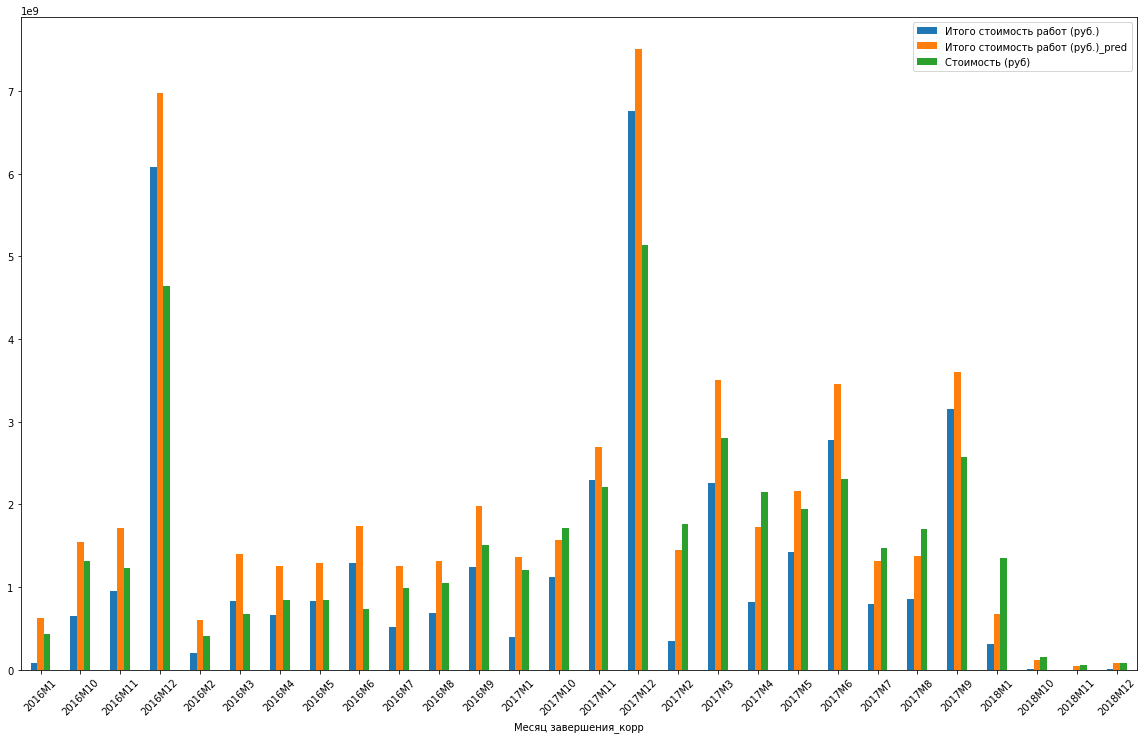

In [21]:
#df_fin_pivot_M.loc['2016M1':'2018M12'].plot(kind='bar', rot=45, figsize=(20,12))

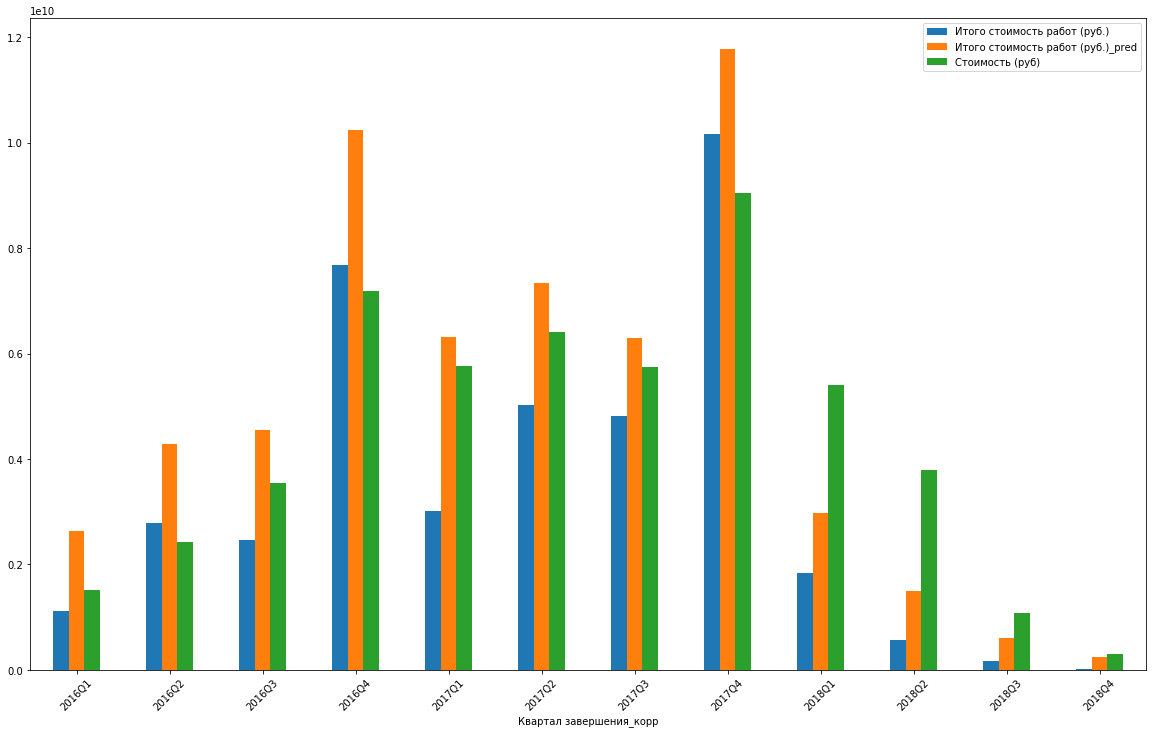

In [22]:
df_fin_pivot_Q.loc['2016Q1':'2018Q4'].plot(kind='bar', rot=45, figsize=(20,12))

In [23]:
df_fin_pivot_M

,Итого стоимость работ (руб.),Итого стоимость работ (руб.)_pred,Стоимость (руб)
Месяц завершения_корр,,,
2010M10,NaN,1.870289e+05,1.589796e+05
2011M8,NaN,1.130382e+06,7.504000e+05
2012M10,NaN,2.789741e+06,2.068971e+06
2012M11,NaN,2.404272e+06,2.644335e+06
2012M12,NaN,2.545814e+06,1.470287e+06
2012M3,NaN,9.182177e+05,3.987070e+05
2012M4,NaN,4.811068e+05,2.941952e+05
2012M8,NaN,2.467675e+05,9.765205e+04
2012M9,NaN,5.300309e+05,2.697648e+05


In [24]:
df_fin_pivot_Q

,Итого стоимость работ (руб.),Итого стоимость работ (руб.)_pred,Стоимость (руб)
Квартал завершения_корр,,,
2010Q4,NaN,1.870289e+05,1.589796e+05
2011Q3,NaN,1.130382e+06,7.504000e+05
2012Q1,NaN,9.182177e+05,3.987070e+05
2012Q2,NaN,4.811068e+05,2.941952e+05
2012Q3,NaN,7.767984e+05,3.674168e+05
2012Q4,NaN,7.739828e+06,6.183593e+06
2013Q1,NaN,3.362243e+06,4.532886e+05
2013Q2,NaN,2.655758e+07,1.679174e+07
2013Q3,NaN,4.858246e+07,4.185371e+06


In [28]:
#если хотим сохранить и восстановить результаты расчётов
#import pickle as pk

#jar = open('data\\rf.pk', 'wb')
#pk.dump(models, jar) # записать сериализованные данные в jar
#jar.close()

#pkl_file = open('data\\rf.pk', 'rb') # открываем
#models = pickle.load(pkl_file) # сохраняем в переменную
#pkl_file.close()